In [17]:
#####Hierarchical Tensor Factorization model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy
import itertools
import scipy.stats as ss
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
from scipy import sparse

In [18]:
####データの発生####
##データの設定
k = 10   #基底数
hh = 10000   #ユーザー数
item = 3000   #アイテム数
context = 24   #コンテキスト数
pt = np.random.poisson(np.random.gamma(25, 1/0.25, hh), hh)   #ユーザーあたりのレコード数
hhpt = np.sum(pt)   #総レコード数
vec_k = np.repeat(1, k)

In [19]:
##IDとインデックスの設定
#IDの設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [20]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, item), topic)
theta = np.random.dirichlet(np.repeat(0.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [21]:
##コンテキストの割当を生成
#トピック割当を生成
topic = 15
phi = np.random.dirichlet(np.repeat(0.25, context), topic)
theta = np.random.dirichlet(np.repeat(0.25, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
context_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    context_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(context))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [22]:
#アイテムとコンテキストのインデックスを作成
index = np.array(range(hhpt))
item_list = [j for j in range(item)]
context_list = [j for j in range(context)]
for j in range(item):
    item_list[j] = index[item_id==j]
for j in range(context):
    context_list[j] = index[context_id==j]

In [23]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)

    ##パラメータを生成
    #階層モデルのパラメータを生成
    alpha_u = 5.5; alpha_ut = alpha_u
    tau_u = 0.75; tau_v = 1.0; tau_c = 0.5
    tau_ut = tau_u; tau_vt = tau_v; tau_ct = tau_c
    Cov_u = np.diag(np.random.uniform(0.1, 0.75, k))
    Cov_v = np.diag(np.random.uniform(0.1, 0.75, k))
    Cov_c = np.diag(np.random.uniform(0.1, 0.75, k))
    Cov_ut = Cov_u; Cov_vt = Cov_v; Cov_ct = Cov_c

    #モデルパラメータを生成
    Sigma = 0.5; Sigmat = Sigma
    beta_u = np.random.normal(alpha_u, tau_u, hh)
    beta_v = np.random.normal(0, tau_v, item)
    beta_c = np.random.normal(0, tau_c, context)
    beta_ut = beta_u; beta_vt = beta_v; beta_ct = beta_c
    theta_u = np.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)
    theta_v = np.random.multivariate_normal(np.repeat(0, k), Cov_v, item)
    theta_c = np.random.multivariate_normal(np.repeat(0, k), Cov_c, context)
    theta_ut = theta_u; theta_vt = theta_v; theta_ct = theta_c
    
    #正規分布からスコアを生成
    uvc = np.dot(theta_u[user_id, ] * theta_v[item_id, ] * theta_c[context_id, ], vec_k)
    mu = beta_u[user_id] + beta_v[item_id] + beta_c[context_id] + uvc
    y_vec = mu + np.random.normal(0, Sigma, hhpt)

    #収束条件
    if (np.mean(y_vec) < 6.0) & (np.mean(y_vec) > 4.5) & (np.std(y_vec) > 1.75) & (np.std(y_vec) < 2.0):
        break

1
2
3
4
5
6
7
8


[5.54118976 5.54050823]
[1.80597829 1.78750606]


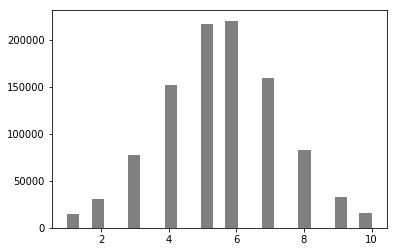

In [24]:
##応答変数をスコアに変換
y = np.round(y_vec)
y[y > 10] = 10; y[y < 1] = 1
print(np.append(np.mean(y_vec), np.mean(y)))
print(np.append(np.std(y_vec), np.std(y)))
plt.hist(y, bins=25, color="grey", histtype="barstacked")
plt.show()

In [25]:
#####モンテカルロEMアルゴリズムでHierarchical Tensor Factorization modelを推定####
##アルゴリズムの設定
LL1 = -1000000000   #対数尤度の初期値
tol = 0.25
iter = 1
dl = 100
L = 500   #モンテカルロサンプリング数

In [30]:
##パラメータの真値
#階層モデルのパラメータ
alpha_u = alpha_ut
tau_u = tau_ut; tau_v = tau_vt; tau_c = tau_ct
Cov_u = Cov_ut
Cov_v = Cov_vt
Cov_c = Cov_ct
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)
inv_Cov_c = np.linalg.inv(Cov_c)

#モデルパラメータの生成
Sigma = Sigmat
beta_u = beta_ut
beta_v = beta_vt
beta_c = beta_ct
theta_u = theta_ut
theta_v = theta_vt
theta_c = theta_ct

In [36]:
##パラメータの初期値
#階層モデルのパラメータ
alpha_u = np.mean(y)
tau_u = 0.3; tau_v = 0.3; tau_c = 0.2
Cov_u = np.diag(np.repeat(0.1, k))
Cov_v = np.diag(np.repeat(0.1, k))
Cov_c = np.diag(np.repeat(0.1, k))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)
inv_Cov_c = np.linalg.inv(Cov_c)

#モデルパラメータの生成
Sigma = 0.5
beta_u = np.random.normal(alpha_u, tau_u, hh)
beta_v = np.random.normal(0, tau_v, item)
beta_c = np.random.normal(0, tau_c, context)
theta_u = np.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)
theta_v = np.random.multivariate_normal(np.repeat(0, k), Cov_v, item)
theta_c = np.random.multivariate_normal(np.repeat(0, k), Cov_c, context)

In [37]:
##テンソルと期待値の初期値
#変量効果とテンソルの設定
beta_u_vec = beta_u[user_id]
beta_v_vec = beta_v[item_id]
beta_c_vec = beta_c[context_id]
uvc = np.dot(theta_u[user_id, ] * theta_v[item_id, ] * theta_c[context_id, ], vec_k)

#期待値を設定
mu = beta_u_vec + beta_v_vec + beta_c_vec + uvc

3435680.85543476